# Getting the necessary data

You just need to do this only once

In [1]:
!rm -f genotypes.vcf.gz 2>/dev/null
!tabix -fh ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/supporting/vcf_with_sample_level_annotation/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5_extra_anno.20130502.genotypes.vcf.gz 22:1-17000000|bgzip -c > genotypes.vcf.gz
!tabix -p vcf genotypes.vcf.gz

In [1]:
from collections import defaultdict

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import vcf

### 1. Inspecting the information that we can get per record

In [2]:
v = vcf.Reader(filename='../datasets/genotypes.vcf.gz')

print('Variant Level information')
infos = v.infos
for info in infos:
    print(info)

print('Sample Level information')
fmts = v.formats
for fmt in fmts:
    print(fmt)

Variant Level information
CIEND
CIPOS
CS
END
IMPRECISE
MC
MEINFO
MEND
MLEN
MSTART
SVLEN
SVTYPE
TSD
AC
AF
NS
AN
ASN_AF
EUR_AF
AFR_AF
AMR_AF
SAN_AF
DP
Sample Level information
GT
DP


### 2. inspect a single VCF record
We will start by retrieving the standard information: the chromosome, position, identifier, reference base, (typically just one), alternative bases (you can have more than one, but it's not uncommon as a first filtering approach to only accept a single ALT, for example, only accept biallelic SNPs), quality (as you might expect, Phred-scaled), and filter status. Regarding the filter status, remember that whatever the VCF file says, you may still want to apply extra filters (as in the next recipe).

In [3]:
v = vcf.Reader(filename='../datasets/genotypes.vcf.gz')
rec = next(v)
print(rec.CHROM, rec.POS, rec.ID, rec.REF, rec.ALT, rec.QUAL, rec.FILTER)
print(rec.INFO)
print(rec.FORMAT)
samples = rec.samples
print(len(samples))
sample = samples[0]
print(sample.called, sample.gt_alleles, sample.is_het, sample.is_variant, sample.phased)
print(int(sample['DP']))

22 16050075 None A [G] 100 []
{'AC': [1], 'AF': [0.000199681], 'AN': 5008, 'NS': 2504, 'DP': [8012], 'ASN_AF': [0.0], 'AMR_AF': [0.0], 'SAS_AF': ['0.0010'], 'EUR_AF': [0.0], 'EAS_AF': [None], 'AFR_AF': [0.0], 'SAN_AF': [0.0]}
GT:DP
2504
True ['0', '0'] False False True
1


We then print the additional variant-level information (AC, AS, AF, AN, DP, and so on), followed by the sample format (in this case, DP and GT). Finally, we count the number of samples and inspect a single sample to check whether it was called for this variant. Also, the reported alleles, heterozygosity, and phasing status (this dataset happens to be phased, which is not that common) are included.

### 3. check the type of variant and the number of nonbiallelic SNPs in a single pass

In [4]:
f = vcf.Reader(filename='../datasets/genotypes.vcf.gz')

my_type = defaultdict(int)
num_alts = defaultdict(int)

for rec in f:
    my_type[rec.var_type, rec.var_subtype] += 1
    if rec.is_snp:
        num_alts[len(rec.ALT)] += 1
print(my_type)
print(num_alts)

defaultdict(<class 'int'>, {('snp', 'ts'): 129, ('snp', 'tv'): 65, ('sv', 'CNV'): 1, ('indel', 'del'): 3, ('snp', 'unknown'): 2, ('indel', 'ins'): 1})
defaultdict(<class 'int'>, {1: 194, 2: 2})


In [5]:
f = vcf.Reader(filename='../datasets/genotypes.vcf.gz')

sample_dp = defaultdict(int)
for rec in f:
    if not rec.is_snp or len(rec.ALT) != 1:
        continue
    for sample in rec.samples:
        dp = sample['DP']
        if dp is None:
            dp = 0
        dp = int(dp)
        sample_dp[dp] += 1

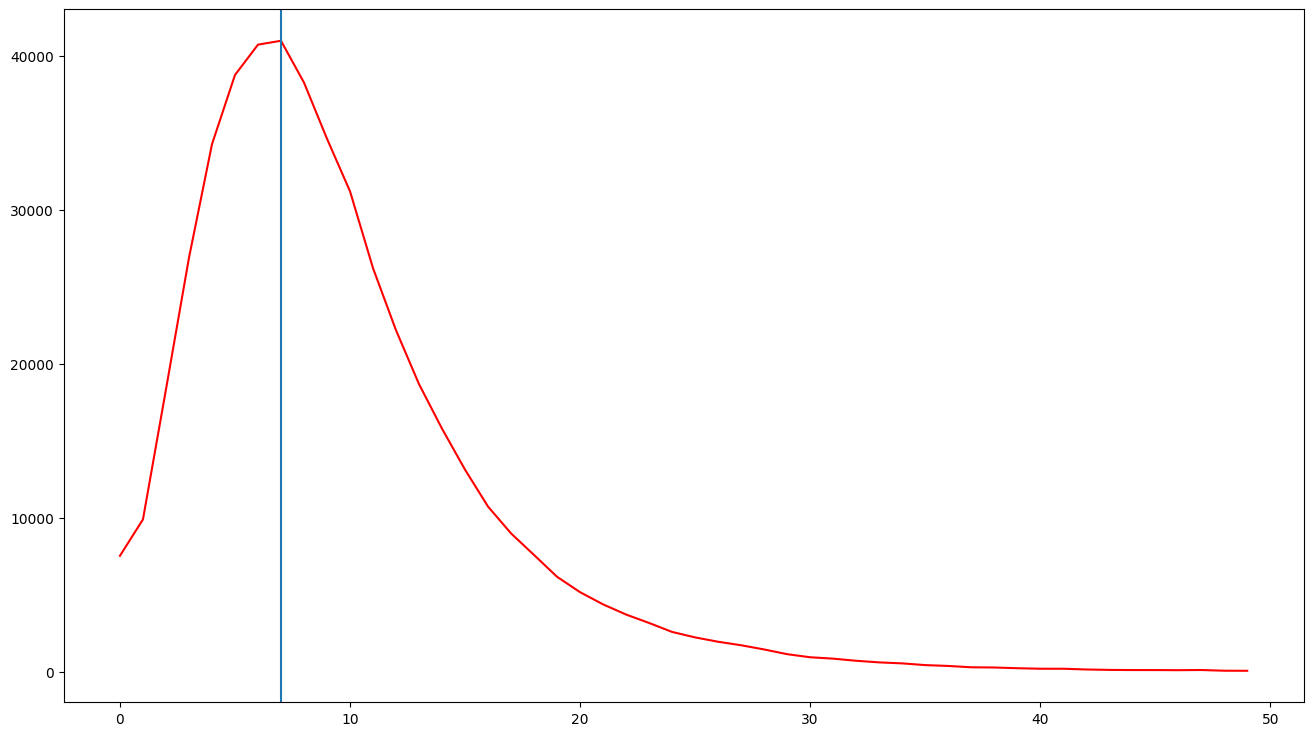

In [6]:
dps = list(sample_dp.keys())
dps.sort()
dp_dist = [sample_dp[x] for x in dps]
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(dp_dist[:50], 'r')
ax.axvline(dp_dist.index(max(dp_dist)))